<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Financial_Objects_and_Morphisms_in_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=2106506c6f2c8522365da7c8d37f3d1fd40855c7139584ba5189a6e64b18859e
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - loss: 0.0313 - val_loss: 6.7060e-04
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0029 - val_loss: 5.4856e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0025 - val_loss: 7.7509e-04
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0024 - val_loss: 4.5333e-04
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0024 - val_loss: 6.4178e-04
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0021 - val_loss: 4.2318e-04
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0021 - val_loss: 4.3673e-04
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0017 - val_loss: 3.8755e-04
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0016 - val_loss: 4.9766e-04
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.0023 - val_loss: 4.5567e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Mean Squared Error no conjunto de teste: 0.03655242707013399


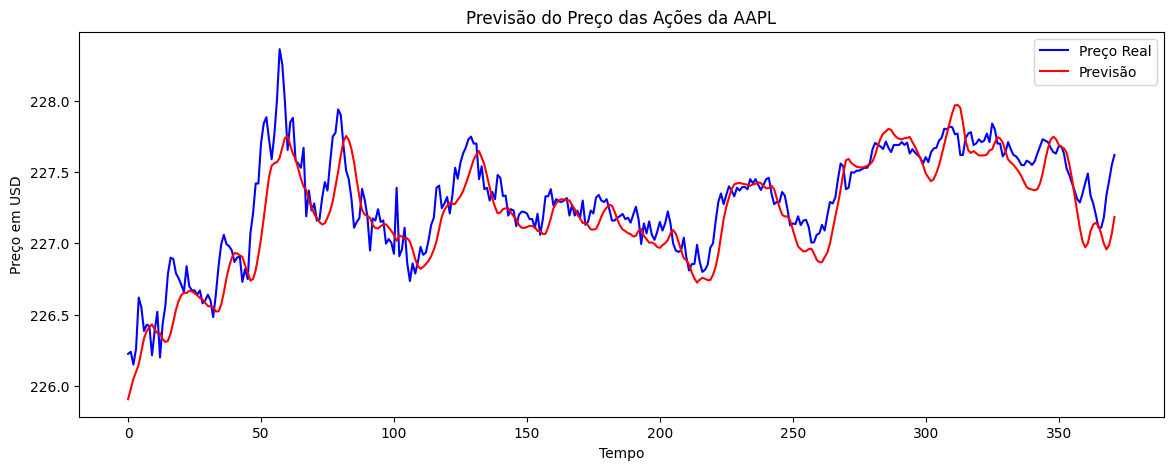

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Preço atual: $227.62
Preço previsto para a próxima hora: $227.27
Indicação: VENDER


In [ ]:
# 1. Importando Bibliotecas Necessárias
!pip install ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

# 2. Coleta de Dados Intradiários
end_date = datetime.now()
start_date = end_date - timedelta(days=7)  # Últimos 7 dias
df = yf.download('AAPL', start=start_date, end=end_date, interval='1m')
df.dropna(inplace=True)

# 3. Preparação dos Dados
import ta
df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()
df['Volume'] = df['Volume']
df.dropna(inplace=True)

features = ['Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'ATR']
data = df[features]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 4. Criação de Sequências e Divisão dos Dados
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i, 0])  # O target é o preço de fechamento ('Close')
    return np.array(X), np.array(y)

sequence_length = 60  # 60 minutos
X, y = create_sequences(scaled_data, sequence_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Construção e Treinamento do Modelo
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 6. Avaliação do Modelo
predictions = model.predict(X_test)

y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
predictions_unscaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

mse = mean_squared_error(y_test_unscaled, predictions_unscaled)
print(f"Mean Squared Error no conjunto de teste: {mse}")

plt.figure(figsize=(14,5))
plt.plot(y_test_unscaled, color='blue', label='Preço Real')
plt.plot(predictions_unscaled, color='red', label='Previsão')
plt.title('Previsão do Preço das Ações da AAPL')
plt.xlabel('Tempo')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

# 7. Previsão para a Próxima Hora
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, scaled_data.shape[1]))

future_price_scaled = model.predict(last_sequence)
future_price = scaler.inverse_transform(np.concatenate((future_price_scaled, np.zeros((future_price_scaled.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
current_price = data['Close'].iloc[-1]
print(f"Preço atual: ${current_price:.2f}")
print(f"Preço previsto para a próxima hora: ${future_price[0]:.2f}")

# 8. Indicação de Compra ou Venda
if future_price[0] > current_price:
    print("Indicação: COMPRAR")
else:
    print("Indicação: VENDER")
